# Projet P4 - Anticipez les besoins en consommation de bâtiments
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 12/2023*
<hr>

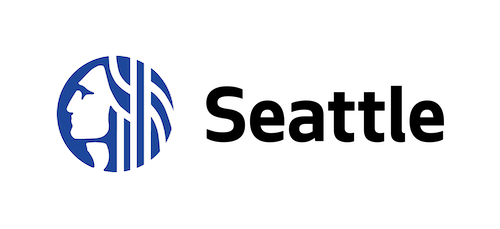

## <font color='#46abe6'>Sommaire : Notebook 2 - Prédiction de la consommation d'énergie 'SiteEnergyUse(kBtu)'</font>

<span style='background:#d5155b'><span style='color:white'>**Notebook 2_1 - Sélection du modèle**</span></span>

[Partie 1 - Importation des librairies et des données](#partie_1)
* [1.1. Importation des librairies](#1_1)
* [1.2. Définition des fonctions](#1_2)
* [1.3. Importation des données](#1_3)

[Partie 2 - Sélection du meilleur modèle](#partie_2)
* [2.1. Transformation des variables](#2_1)
* [2.2. Séparation échantillons entraînement et test](#2_2)
* [2.3. Standardisation et Encodage des variables catégorielles](#2_3)
* [2.4. Entraînement et test des différents modèles](#2_4)

<span style='background:#46abe6'><span style='color:white'>**Notebook 2_2 - Optimisation du modèle**</span></span>

[Partie 3 - Optimisation du meilleur modèle](#partie_3)

[Partie 4 - Feature importance globale et locale](#partie_4)

<span style='background:#46abe6'><span style='color:white'>**Notebook 2_3 - Evaluation de l'influence de EnergyStarScore**</span></span>

[Partie 5 - Evaluation de l'influence de EnergyStarScore](#partie_5)


# <font color='#0a389f'>Partie 1 - Importation des librairies et des données<a class="anchor" id="partie_1"></a></font>

## <font color='#46abe6'>1.1. Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

# graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# affichage Markdown des Outputs
from IPython.display import Markdown 

# Encodeur pour les variables catégorielles
from sklearn.preprocessing import OneHotEncoder, TargetEncoder

# Standardisation des variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Split entraînement /test
from sklearn.model_selection import train_test_split

# Cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métriques Evaluation du modèle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import time

import scipy.stats as st

# Feature importance
import shap

import pickle

In [2]:
# Version python
!python --version

# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.0
pandas - 2.1.1
seaborn - 0.13.0
shap - 0.44.1


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

In [4]:
# Initialisation de shap 
shap.initjs()

In [5]:
# Options d'affichage : toutes les colonnes et contenu complet de la colonne
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## <font color='#46abe6'>1.2. Définition des fonctions<a class="anchor" id="1_2"></a></font>

In [6]:
def create_preprocessor(encoder, scaler, num_col, cat_col):
    """!
    @brief Crée un preprocesseur pour les données numériques et catégorielles.

    Cette fonction crée un preprocesseur qui applique les transformations spécifiées aux colonnes 
    numériques et catégorielles.

    @param encoder: Encoder pour encoder les variables catégorielles (type : Encoder).
    @param scaler: Scaler pour mettre à l'échelle les variables numériques (type : Scaler).
    @param num_col: Liste des noms des colonnes numériques (type : list[str]).
    @param cat_col: Liste des noms des colonnes catégorielles (type : list[str]).
    
    @return preprocessor: Preprocesseur pour les données numériques et catégorielles (type : ColumnTransformer).
    """
    
    # Columns: num_transformer = scaler, cat_transformer = encoder
    num_transformer = make_pipeline(scaler)
    cat_transformer = make_pipeline(encoder)

    # Associer encoder et scaler avec ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, num_col),
                      ('cat', cat_transformer, cat_col)])

    
    return preprocessor

In [7]:
def search_best_params(pipe, param_grid, X_train, y_train, search_cv='GridSearchCV', score='r2', cv=5):
    """!
    @brief Recherche les meilleurs hyperparamètres pour un pipeline de modèle.

    Cette fonction utilise une recherche de grille ou une recherche aléatoire pour trouver les meilleurs hyperparamètres
    pour un pipeline de modèle donné.

    @param pipe: Pipeline de modèle à optimiser (type : sklearn.pipeline.Pipeline).
    @param param_grid: Grille des hyperparamètres à rechercher (type : dict).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param search_cv: Type de recherche à effectuer ('GridSearchCV' ou 'RandomizedSearchCV') (type : str, valeur par défaut : 'GridSearchCV').
    @param score: La métrique de score à utiliser pour l'optimisation (type : str, valeur par défaut : 'r2').
    @param cv: Le nombre de fold de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    @return best_model: Le meilleur modèle trouvé après l'optimisation des hyperparamètres (type : sklearn.pipeline.Pipeline).
    @return best_params_: Les meilleurs hyperparamètres trouvés (type : dict ou 'NA' si aucune recherche n'est effectuée).
    """
    
    if param_grid:
        # Recherche les meilleurs hyperparamètres par validation croisée
        if search_cv == 'GridSearchCV':
            grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=score, n_jobs=-1)
        elif search_cv == 'RandomizedSearchCV':
            grid_search = RandomizedSearchCV(pipe, param_grid, cv=cv, scoring=score, n_jobs=-1)

        grid_search.fit(X_train, y_train)
        best_params_ = grid_search.best_params_
        best_model = grid_search.best_estimator_
    else:
        # Si le modèle n'a pas d'hyperparamètres, considère pipe comme best_model
        best_model = pipe
        best_params_ = 'NA'

    return best_model, best_params_

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, score='r2', cv=5):
    """!
    @brief Évalue les performances d'un modèle.

    Cette fonction évalue les performances d'un modèle en effectuant une validation croisée,
    en calculant plusieurs métriques de performance sur l'ensemble de test et en fournissant des informations
    sur le temps d'entraînement et de prédiction.

    @param model: Modèle à évaluer (type : sklearn.base.BaseEstimator).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param X_test: Features de test (type : array-like).
    @param y_test: Target de test (type : array-like).
    @param score: La métrique de score à utiliser pour l'évaluation (type : str, valeur par défaut : 'r2').
    @param cv: Le nombre de folds de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    @return results: Dictionnaire contenant les résultats de l'évaluation du modèle (type : dict).
    """    
    # Cross-validation sur le training set
    scores = cross_validate(model, X_train, y_train, scoring=score, cv=cv)
    cv_r2 = scores['test_score'].mean()
    cv_std = np.std(scores['test_score'])

    # Prédiction et scores 
    start_time = time.perf_counter() # début compteur pour les temps d'exécution du modèle
    model.fit(X_train, y_train) # Entraînement du modèle
    fit_time = time.perf_counter() # compteur entraînement
    y_pred = model.predict(X_test) # Prédiction 
    pred_time = time.perf_counter() # compteur prédiction
    y_pred_train = model.predict(X_train) # prédiction de y_train
       
    # Dictionnaire contenant tous les résultats
    results = {
        'cv_r2': cv_r2,
        'cv_std': cv_std,
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'fit_time': fit_time - start_time,
        'pred_time': pred_time - fit_time,
        'y_pred': y_pred,  
        'model': model  
    }

    return results

In [9]:
def process_model(model, 
                  encoder, 
                  scaler, 
                  param_grid, 
                  X_train, y_train, 
                  X_test, y_test, 
                  cat_col, num_col, 
                  score='r2', cv=5):
    """!
    @brief Prétraitement des données, optimisation des hyperparamètres et évaluation du modèle.

    Cette fonction réalise les étapes suivantes :
    1. Création du pipeline avec le préprocesseur et le modèle donnés.
    2. Recherche des meilleurs hyperparamètres du modèle.
    3. Évaluation des performances du modèle sur l'ensemble d'entraînement et de test.

    @param model: Modèle à entraîner et évaluer (type : sklearn.base.BaseEstimator).
    @param encoder: Encoder pour encoder les variables catégorielles (type : Encoder).
    @param scaler: Scaler pour mettre à l'échelle les variables numériques (type : Scaler).
    @param param_grid: Grille des hyperparamètres à rechercher (type : dict).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param X_test: Features de test (type : array-like).
    @param y_test: Target de test (type : array-like).
    @param cat_col: Liste des noms des colonnes catégorielles (type : list[str]).
    @param num_col: Liste des noms des colonnes numériques (type : list[str]).
    @param score: Métrique de score à utiliser pour l'évaluation (type : str, valeur par défaut : 'r2').
    @param cv: Nombre de folds de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    """      
    global eval_df 
    
    # Créer le pipeline
    preprocessor = create_preprocessor(encoder, scaler, num_col, cat_col)
    pipe = make_pipeline(preprocessor, model)
    
    # Recherche des meilleurs hyperparamètres et évaluation du modèle
    best_model, best_params_ = search_best_params(pipe, 
                                                  param_grid, 
                                                  X_train, y_train, 
                                                  search_cv='GridSearchCV', 
                                                  score=score, cv=cv)
    
    # Évaluation du modèle
    results = evaluate_model(best_model, X_train, y_train, X_test, y_test, score='r2', cv=5)

    # Cross-validation et scores sur le testing test : ajout à eval_df
    new_row = pd.DataFrame({
        'Model': str(model),
        'Parameters': str(best_params_),
        'CV_R2 score': "{:.3f} (+/- {:.03f})".format(results['cv_r2'], results['cv_std']),
        'Train_R2 score': round(results['train_r2'], 3),
        'Test_R2 score': round(results['test_r2'], 3),
        'Test_MAE': round(results['MAE'], 3),
        'Test_RMSE': round(results['RMSE'], 3),
        'Fit Time (s)': round(results['fit_time'], 3),
        'Prediction Time (s)': round(results['pred_time'], 3)
    }, index=[0])
    
    # Ajouter la nouvelle ligne à eval_df
    eval_df = pd.concat([eval_df, new_row],ignore_index=True)

In [10]:
def find_best_combination(eval_dict):
    """!
    @brief Trouve la meilleure combinaison de modèle en tenant compte des critères de temps en cas d'égalité 
    sur le Test_R2 score.

    Cette fonction parcourt un dictionnaire contenant les évaluations de différents modèles et leurs combinaisons 
    d'encodeurs et de scalers, et sélectionne la meilleure combinaison en tenant compte des critères de performance 
    et de temps. La fonction affiche le graphique des résultats des modèles pour la combinaison (encodeur, scaler).
    Elle appelle les fonctions find_best_combination_helper() et plot_best_combination_results()

    @param eval_dict: Dictionnaire contenant les évaluations des modèles pour différentes combinaisons d'encodeurs et 
    de scalers (type : dict).

    @return best_combination: Dataframe contenant l'encodeur, le scaler, le modèle et les résultats (type : pd.DataFrame).
    """
    # Récupérer la meilleure combinaison et les résultats
    best_key, best_combination = find_best_combination_helper(eval_dict)
    
    # Affichage de diagrammes à barres pour comparer les modèles de la meilleure combinaison 
    title = f'Comparaison des performances des différents modèles pour la meilleure combinaison Encoder : {best_key[0]}, Scaler : {best_key[1]}'
    plot_metrics_comparison(eval_dict[best_key], 'Model', title, legend_bbox_to_anchor=(1.15,0.5))
    
    # Retourner la meilleure combinaison
    display(Markdown("Les meilleurs résultats de Test_R2 score et Fit time sont obtenus pour :"))
    display(best_combination)
    
    return best_combination


In [11]:
def find_best_combination_helper(eval_dict):
    """!
    @brief Trouve la meilleure combinaison de modèle en tenant compte des critères de temps en cas d'égalité 
    sur le Test_R2 score.

    Cette fonction parcourt un dictionnaire contenant les évaluations de différents modèles et leurs combinaisons 
    d'encodeurs et de scalers, et sélectionne la meilleure combinaison en tenant compte des critères de performance 
    et de temps.

    @param eval_dict: Dictionnaire contenant les évaluations des modèles pour différentes combinaisons d'encodeurs et 
    de scalers (type : dict).
    
    @return best_key: Clé de recherche dans le dictionnaire (Encoder, Scaler) correspondant à la meilleure 
    combinaison (type : tuple).
    @return best_combination: Dataframe contenant l'encodeur, le scaler, le modèle et les résultats (type : pd.DataFrame).
    """
    # initialisation des paramètres
    best_score = 0
    best_results = None
    best_encoder = None
    best_scaler = None
    best_fit_time = float('inf')
    
    # Boucle sur chaque combinaison encoder-scaler
    for key, df in eval_dict.items():
        # Trouver l'indice de la ligne avec le meilleur score global
        best_index = np.abs(df['Test_R2 score']).idxmax()
        # Extraire les valeurs correspondantes pour cette ligne
        best_values = df.iloc[best_index]

        # Vérifier si ce score est le meilleur trouvé jusqu'à présent
        if best_values['Test_R2 score'] > best_score:
            best_score = best_values['Test_R2 score']
            best_results = best_values
            best_fit_time = best_values['Fit Time (s)']
            best_key = key                 
            
        elif best_values['Test_R2 score'] == best_score:
            # si égalité des scores, comparer les fit_time et choisir le modèle avec le temps le plus faible 
            if best_values['Fit Time (s)'] < best_fit_time:
                best_score = best_values['Test_R2 score']
                best_results = best_values
                best_key = key
    
    # Concatenation de la meilleure combinaison dans un même df
    best_results = pd.DataFrame({'Value' : best_results})
    best_transform = pd.DataFrame({'Value': best_key}, index=['Encoder', 'Scaler'])
    best_combination = pd.concat([best_transform, best_results])
    
    return best_key, best_combination

In [12]:
def plot_metrics_comparison(df, comparison_feature, title, legend_bbox_to_anchor=(1, 1)):
    """!
    @brief Affiche des diagrammes à barres pour comparer les modèles sur différentes métriques.

    Cette fonction prend un DataFrame contenant les résultats des modèles pour une comparaison spécifique
    et affiche des diagrammes à barres pour chaque métrique spécifiée.

    @param df: DataFrame contenant les résultats des modèles pour une comparaison spécifique (type : pd.DataFrame).
    @param comparison_feature: Nom du test ou de la condition comparé (type : str).
    @param title: Titre du graphique (type : str).
    @param legend_bbox_to_anchor: Position de la légende en termes de coordonnées de la boîte englobante (type : tuple, valeur par défaut : (1, 1)).
    """
    metrics=['Train_R2 score', 'Test_R2 score','Test_MAE', 'Test_RMSE', 'Fit Time (s)', 'Prediction Time (s)']
    
    # Affichage de diagrammes à barres pour comparer les modèles 
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), tight_layout=True)
    axes = axes.flatten()  # liste plate pour itération
    fig.suptitle(title, wrap=True, fontsize=24)

    # un graphique par métrique
    for i, metric in enumerate(metrics):
        plot_data = df[[comparison_feature, metric]].melt(id_vars=[comparison_feature], var_name='Metrics', value_name='Value')
        ax = sns.barplot(data=plot_data, x='Metrics', y='Value', hue=comparison_feature, palette='viridis', ax=axes[i])
        ax.set_title(f'{metric}')
        ax.get_legend().remove()
        
        for bars in ax.containers:
            ax.bar_label(bars, fontsize=15)

    # Afficher la légende avec bbox_to_anchor
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=legend_bbox_to_anchor)
    plt.show()

## <font color='#46abe6'>1.3. Importation des données<a class="anchor" id="1_3"></a></font>

In [13]:
# Importation du dataframe nettoyé
building_data = pd.read_pickle('data_afterEDA.pkl')

In [14]:
building_data.head()

,OSEBuildingID,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,PropertyGFAParking(%),PropertyGFABuilding(%),SteamUse(%),ElectricityUse(%),NaturalGasUse(%)
0,1,Hotel,downtown,1.0,12,88434,7226362.5,249.98,89,0.00,1.00,0.28,0.55,0.18
1,2,Hotel,downtown,1.0,11,103566,8387933.0,295.86,20,0.15,0.85,0.00,0.39,0.61
2,3,Hotel,downtown,1.0,41,956110,72587024.0,2089.28,47,0.21,0.79,0.30,0.68,0.02
3,5,Hotel,downtown,1.0,10,61320,6794584.0,286.43,90,0.00,1.00,0.33,0.41,0.27
4,8,Hotel,downtown,1.0,18,175580,14172606.0,505.01,36,0.35,0.65,0.00,0.38,0.62


# <font color='#0a389f'>Partie 2 - Sélection du meilleur modèle<a class="anchor" id="partie2"></a></font>

**Modèles testés** :
- Baseline : 
    - **DummyRegressor** : Le Dummy Regressor est une méthode simple et naïve utilisée pour la régression. Elle consiste à prédire toutes les valeurs cibles comme étant la moyenne ou la médiane des valeurs observées dans l'ensemble d'entraînement.
    - **LinearRegression** : La régression linéaire cherche à trouver la meilleure droite (ou plan) qui représente au mieux les relations entre les variables. Cette droite est déterminée en minimisant la somme des carrés des résidus (méthode des moindres carrés).
- Méthodes linéaires avec régularisation :
    - **Ridge** : La régression ridge permet d'éviter le surapprentissage en restreignant l'amplitude des poids (utilisation de la norme ℓ2 du vecteur de poids).
    - **Lasso** : La régression lasso permet d'obtenir un modèle parcimonieux, sélection de variables et de réduction de dimension supervisée (utilisation de la norme ℓ1 du vecteur de poids). Par contre, elle est instable.
    - **ElasticNet** : La régression Elasticnet combine les régularisations ridge et lasso pour obtenir un compromis entre une solution parcimonieuse et stable et dans laquelle toutes les variables corrélées pertinentes pour la prédiction de l'étiquette sont sélectionnées et reçoivent un poids identique.
- Méthodes non linéaires :
    - **Support Vector Regressor** : Le Support Vector Regressor (SVR) utilise une extension des Support Vector Machines appelée "SVM à noyau". Ces SVM à noyau permettent de capturer des relations non linéaires entre les variables en transformant les données dans un espace de plus grande dimension, où elles peuvent être plus facilement séparées par un hyperplan. Ainsi, le SVR peut trouver des fonctions de régression plus complexes en utilisant des noyaux pour ajuster les données d'une manière plus flexible et précise.
 - Méthodes ensemblistes : 
     - **parallèles - Random Forest Regressor** : Le modèle Random Forest combine plusieurs arbres de décision pour former un modèle robuste. Il utilise un sous-ensemble aléatoire des caractéristiques disponibles à chaque nœud pour réduire la corrélation entre les arbres. Chaque arbre de décision prédit une valeur et la prédiction finale est obtenue en agrégeant ces valeurs (moyenne).
    - **séquentielles :  GradientBoostingRegressor** : Le modèle GradientBoostingRegressor est un modèle additif qui combine plusieurs apprenants faibles pour minimiser une fonction de perte différentiable en suivant le gradient. Il fonctionne de manière séquentielle, en ajustant itérativement de nouveaux modèles pour corriger les erreurs des modèles précédents. Ainsi, il obtient une prédiction plus précise en agrégeant les prédictions de tous les modèles.
    
    
**Perspectives** : d'autres modèles pourraient être testés K-Nearest Neighbor (kNN) ou des modèles ensemblistes séquentiels avec gradient boosting :  XGBoost, LightGBM.


## <font color='#46abe6'>2.1. Transformation des variables<a class="anchor" id="2_1"></a></font>

Lors de l'analyse exploratoire, nous avons pu observer que les distributions des variables `NumberofFloors`, `PropertyGFATotal` et `SiteEnergyUse(kBtu)` étaient très asymétriques : désaxées vers la droite (longue queue à droite). La **transformation logarithmique** a permis de :
- **Normaliser la distribution** : la distribution des données est plus proche de la normalité
- **Réduire l'impact des valeurs extrêmes** : éviter un impact disproportionné des valeurs extrêmes en resserrant la distribution et rendre le modèle plus robuste aux valeurs aberrantes.

Cela peut aider la convergence de certains algorithmes.

In [15]:
# Transformation au log
building_data['log_NumberofFloors'] = np.log10(building_data['NumberofFloors'])
building_data['log_PropertyGFATotal'] = np.log10(building_data['PropertyGFATotal'])
building_data['log_SiteEnergyUse(kBtu)'] = np.log10(building_data['SiteEnergyUse(kBtu)'])

## <font color='#46abe6'>2.2. Séparation échantillons entraînement et test<a class="anchor" id="2_2"></a></font>

Le dataset est séparé en un jeu d'entraînement et un jeu de test. 
- Le **jeu de test** ne sera utilisé que pour mesurer l’erreur du modèle final sur des données qu’il n’a jamais vues : évaluer l'**erreur de généralisation**. 
- Le **jeu d'entraînement** sera donc utilisé pour l'**entraînement** du modèle, l'**optimisation des hyperparamètres** et la **sélection du modèle**. 

Validation croisée :
- La **validation croisée** va nous permettre d’utiliser l’**intégralité de notre jeu de d'entraînement** pour l’**entraînement** et pour la **validation**. Le jeu d'entraînement est découpé en k parties à peu près égales. Tour à tour, chacune des k parties est utilisée comme jeu de validation. Le reste (autrement dit, l’union des k-1 autres parties) est utilisé pour l’**entraînement** et pour **affiner les hyper-paramètres des modèles**. La sélection du modèle se fait sans jamais avoir validé le modèle sur une donnée déjà apprise.

Le meilleur modèle sélectionné sera ensuite entraîné sur le jeu d'entraînement complet puis évaluer sur le jeu de test.

In [16]:
seed = 0

# Définition des variables d'entrée X et de la target y
X = building_data[['PrimaryPropertyType', 
                   'Neighborhood', 
                   'BuildingAge',
                   'NumberofBuildings', 
                   'log_NumberofFloors', 
                   'log_PropertyGFATotal',
                   'PropertyGFAParking(%)',
                   'PropertyGFABuilding(%)', 
                   'SteamUse(%)', 
                   'ElectricityUse(%)',
                   'NaturalGasUse(%)']]

y = building_data['log_SiteEnergyUse(kBtu)']

In [17]:
# Création de l'échantillon d'entraînement et de l'échantillon de test
# Stratify = répartition homogène de 'PrimaryPropertyType' dans les échantillons de test et entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=building_data['PrimaryPropertyType'], 
                                                    random_state = seed)

In [18]:
# Sauvegarder les datasets d'entraînement et de test
pickle.dump((X_train, X_test, y_train, y_test), open('train_test_energy.pkl', 'wb'))

In [19]:
# Taille des datasets d'entraînement et de test
display(Markdown(f"Dimensions du dataset d'entraînement = {X_train.shape} et du dataset de test = {X_test.shape}"))

Dimensions du dataset d'entraînement = (1059, 11) et du dataset de test = (265, 11)

## <font color='#46abe6'>2.3. Encodage des variables catégorielles et Standardisation des variables numériques<a class="anchor" id="2_3"></a></font>

- **Encodage** :  Les algorithmes de machine learning nécessitent des données numériques : il est donc nécessaire de transformer, encoder, les variables catégorielles. Il existe différents types d'encodeurs : 
    - **One-hot encoding :** pour une variable catégorielle X avec K modalités m1, m2, …, mK. Le one hot encoding consiste à créer K variables indicatrices, soit un vecteur de taille K qui a des 0 partout et un 1 à la position i correspondant à la modalité mi. On remplace donc la variable catégorielle par K variables numériques. Point négatif : ajoute autant de variables que de modalités.
    - **Target encoding :** Plutôt que de créer de nouvelles variables, cette méthode remplace chaque catégorie par la moyenne de la variable cible pour les observations associées à cette catégorie. Cela peut être utile pour capturer les relations entre les variables catégorielles et la variable cible. Point négatif : peut conduire à un surajustement si la variable cible est utilisée pour encoder les données d'entraînement.
    
- **Standardisation des données** : La standardisation permet une mise à l'échelle des données et un centrage autour de zéro. Cela permet de ne pas introduire de biais dans le modèle pour la feature importance. 
    - **StandardScaler** : soustrait la moyenne de chaque caractéristique puis divise par l'écart-type de cette caractéristique. Cela garantit que chaque caractéristique a une moyenne de 0 et une variance de 1. Point négatif : Sensible aux valeurs aberrantes.
    - **RobustScaler**: utilise la médiane et le quartile au lieu de la moyenne et de l'écart-type ce qui le rend plus robuste aux valeurs aberrantes.

In [20]:
# Définition des variables à encoder et standardiser
cat_col = ['Neighborhood', 
           'PrimaryPropertyType']

num_col = X_train.columns.difference(cat_col).to_list()

## <font color='#46abe6'>2.4. Entraînement et test des différents modèles<a class="anchor" id="2_4"></a></font>

- Evaluation des performances des modèles :
    - $R^{2}$ : Coefficient de détermination, plus il est proche de 1, meilleure est la corrélation.

    Pour les métriques suivantes, on cherchera la valeur la plus petite 
    - $MAE$ : Mean Absolute Error, moyenne de la valeur absolue de la sommes des carrés des résidus
    - $RMSE$ : Root Mean Squared Error, racine carrée de la MSE

La métrique qui a le plus de sens pour une régression est le coefficient de détermination $R^{2}$ : c'est celui qui sera utilisé comme score pour la validation croisée.

In [21]:
# Création d'un dictionnaire de modèles avec leurs paramètres
models = {
    'Dummy Regressor' : (DummyRegressor(), {'dummyregressor__strategy': ['mean', 'median']}),
    
    'Linear Regression': (LinearRegression(), {}),
    
    'Ridge Regression' : (Ridge(), {'ridge__alpha': np.linspace(0.01, 1, 5)}),
    
    'Lasso Regression' : (Lasso(), {'lasso__alpha': np.linspace(0.01, 1, 5)}),
    
    'ElasticNet Regression' : (ElasticNet(), {'elasticnet__alpha': np.linspace(0.01, 1, 5)}),
    
    'SVR' : (SVR(), {'svr__kernel' : ['linear', 'rbf']}),
             
    'Random Forest' : (RandomForestRegressor(), {'randomforestregressor__n_estimators': [100, 200, 300]}),
             
    'Gradient Boosting' : (GradientBoostingRegressor(),
                           {'gradientboostingregressor__n_estimators':[100, 200, 300]})      
}

# Définir une liste d'encodeurs et de scalers à tester
encoders = [OneHotEncoder(), TargetEncoder()]  # Liste des encodeurs
scalers = [StandardScaler(), RobustScaler()]   # Liste des scalers

In [22]:
%%time
# Initialiser un dictionnaire pour stocker les dataframes d'évaluation pour chaque combinaison encoder-scaler
eval_dict = {}

# Boucle sur chaque encodeur et scaler pour collecter les résultats
for encoder in encoders:
    for scaler in scalers:
        # Initialisation de eval_df
        eval_df = pd.DataFrame()  # dataframe d'évaluation pour cette combinaison
        
        # Boucle sur chaque modèle et ses paramètres
        for model_name, (model, param_grid) in models.items():
            process_model(model=model,
                          encoder=encoder,
                          scaler=scaler,
                          param_grid=param_grid,
                          X_train=X_train, y_train=y_train,
                          X_test=X_test, y_test=y_test,
                          cat_col=cat_col, num_col=num_col,
                          score='r2', cv=5)
        # Afficher les dataframes résultats pour chaque combinaison encoder-scaler
        print(f"Combinaison Encoder: {encoder}, Scaler: {scaler}")
        display(eval_df)
        # Ajouter le dataframe d'évaluation à eval_dict
        eval_dict[(encoder, scaler)] = eval_df  

Combinaison Encoder: OneHotEncoder(), Scaler: StandardScaler()


,Model,Parameters,CV_R2 score,Train_R2 score,Test_R2 score,Test_MAE,Test_RMSE,Fit Time (s),Prediction Time (s)
0,DummyRegressor(),{'dummyregressor__strategy': 'mean'},-0.002 (+/- 0.002),0.000,-0.000,0.438,0.548,0.015,0.010
1,LinearRegression(),NA,0.729 (+/- 0.018),0.752,0.742,0.200,0.278,0.026,0.007
2,Ridge(),{'ridge__alpha': 1.0},0.729 (+/- 0.019),0.752,0.743,0.200,0.278,0.025,0.007
3,Lasso(),{'lasso__alpha': 0.01},0.662 (+/- 0.024),0.674,0.690,0.225,0.305,0.016,0.006
4,ElasticNet(),{'elasticnet__alpha': 0.01},0.698 (+/- 0.022),0.709,0.726,0.210,0.287,0.031,0.010
5,SVR(),{'svr__kernel': 'linear'},0.731 (+/- 0.021),0.749,0.745,0.198,0.277,0.342,0.015
6,RandomForestRegressor(),{'randomforestregressor__n_estimators': 300},0.706 (+/- 0.021),0.962,0.715,0.210,0.293,8.906,0.100
7,GradientBoostingRegressor(),{'gradientboostingregressor__n_estimators': 100},0.731 (+/- 0.013),0.826,0.748,0.200,0.275,0.480,0.011


Combinaison Encoder: OneHotEncoder(), Scaler: RobustScaler()


,Model,Parameters,CV_R2 score,Train_R2 score,Test_R2 score,Test_MAE,Test_RMSE,Fit Time (s),Prediction Time (s)
0,DummyRegressor(),{'dummyregressor__strategy': 'mean'},-0.002 (+/- 0.002),0.000,-0.000,0.438,0.548,0.015,0.009
1,LinearRegression(),NA,0.729 (+/- 0.018),0.752,0.742,0.200,0.278,0.027,0.006
2,Ridge(),{'ridge__alpha': 1.0},0.730 (+/- 0.018),0.752,0.744,0.200,0.277,0.029,0.009
3,Lasso(),{'lasso__alpha': 0.01},0.659 (+/- 0.024),0.670,0.686,0.225,0.307,0.021,0.008
4,ElasticNet(),{'elasticnet__alpha': 0.01},0.695 (+/- 0.022),0.705,0.725,0.211,0.287,0.023,0.008
5,SVR(),{'svr__kernel': 'linear'},0.731 (+/- 0.021),0.749,0.745,0.198,0.277,0.182,0.018
6,RandomForestRegressor(),{'randomforestregressor__n_estimators': 200},0.704 (+/- 0.022),0.961,0.709,0.212,0.296,5.935,0.067
7,GradientBoostingRegressor(),{'gradientboostingregressor__n_estimators': 100},0.730 (+/- 0.013),0.826,0.748,0.200,0.275,0.426,0.008


Combinaison Encoder: TargetEncoder(), Scaler: StandardScaler()


,Model,Parameters,CV_R2 score,Train_R2 score,Test_R2 score,Test_MAE,Test_RMSE,Fit Time (s),Prediction Time (s)
0,DummyRegressor(),{'dummyregressor__strategy': 'mean'},-0.002 (+/- 0.002),0.000,-0.000,0.438,0.548,0.013,0.005
1,LinearRegression(),NA,0.679 (+/- 0.010),0.693,0.696,0.228,0.302,0.019,0.006
2,Ridge(),{'ridge__alpha': 1.0},0.679 (+/- 0.011),0.693,0.696,0.228,0.302,0.015,0.006
3,Lasso(),{'lasso__alpha': 0.01},0.675 (+/- 0.011),0.685,0.691,0.227,0.305,0.017,0.008
4,ElasticNet(),{'elasticnet__alpha': 0.01},0.677 (+/- 0.011),0.689,0.693,0.228,0.303,0.026,0.008
5,SVR(),{'svr__kernel': 'rbf'},0.680 (+/- 0.021),0.703,0.706,0.221,0.297,0.097,0.045
6,RandomForestRegressor(),{'randomforestregressor__n_estimators': 300},0.701 (+/- 0.016),0.923,0.728,0.206,0.286,3.048,0.066
7,GradientBoostingRegressor(),{'gradientboostingregressor__n_estimators': 100},0.717 (+/- 0.017),0.825,0.740,0.202,0.279,0.326,0.007


Combinaison Encoder: TargetEncoder(), Scaler: RobustScaler()


,Model,Parameters,CV_R2 score,Train_R2 score,Test_R2 score,Test_MAE,Test_RMSE,Fit Time (s),Prediction Time (s)
0,DummyRegressor(),{'dummyregressor__strategy': 'mean'},-0.002 (+/- 0.002),0.000,-0.000,0.438,0.548,0.016,0.005
1,LinearRegression(),NA,0.679 (+/- 0.011),0.692,0.695,0.228,0.303,0.023,0.008
2,Ridge(),{'ridge__alpha': 0.505},0.679 (+/- 0.011),0.693,0.696,0.228,0.302,0.017,0.005
3,Lasso(),{'lasso__alpha': 0.01},0.672 (+/- 0.009),0.683,0.688,0.227,0.306,0.017,0.006
4,ElasticNet(),{'elasticnet__alpha': 0.01},0.675 (+/- 0.010),0.686,0.692,0.227,0.304,0.017,0.006
5,SVR(),{'svr__kernel': 'rbf'},0.682 (+/- 0.013),0.696,0.698,0.223,0.301,0.066,0.028
6,RandomForestRegressor(),{'randomforestregressor__n_estimators': 100},0.705 (+/- 0.024),0.925,0.728,0.208,0.286,0.876,0.035
7,GradientBoostingRegressor(),{'gradientboostingregressor__n_estimators': 100},0.709 (+/- 0.023),0.818,0.732,0.207,0.284,0.329,0.007


CPU times: total: 1min 11s
Wall time: 2min 47s


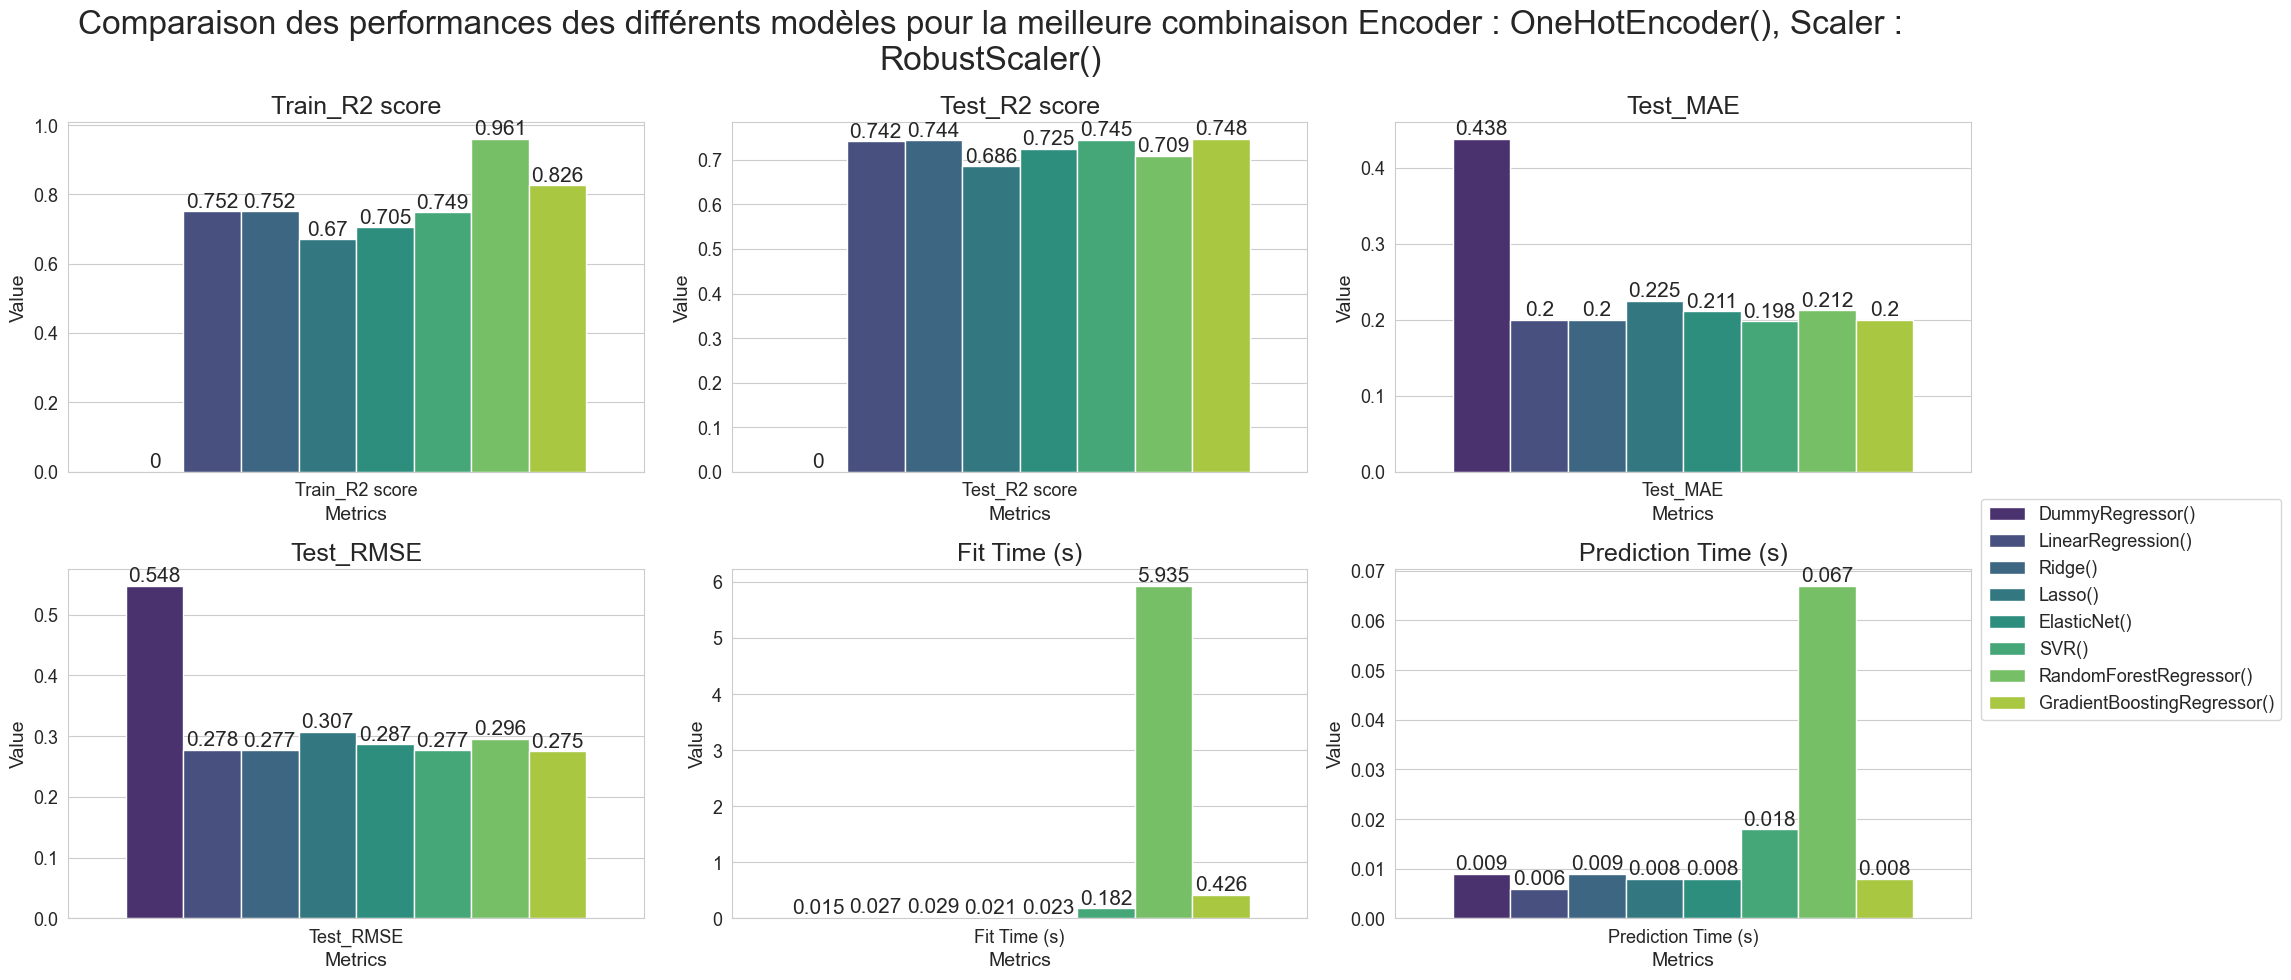

Les meilleurs résultats de Test_R2 score et Fit time sont obtenus pour :

,Value
Encoder,OneHotEncoder()
Scaler,RobustScaler()
Model,GradientBoostingRegressor()
Parameters,{'gradientboostingregressor__n_estimators': 100}
CV_R2 score,0.730 (+/- 0.013)
Train_R2 score,0.826
Test_R2 score,0.748
Test_MAE,0.2
Test_RMSE,0.275
Fit Time (s),0.426


In [23]:
# Affichage de la combinaison avec les meilleurs résultats
best_combination = find_best_combination(eval_dict)

En tenant compte des critères R² et fit & predict times, les meilleurs résultats sont obtenus avec :
- Encoder : OneHotEncoder
- Scaler : RobustScaler 
- Modèle : GradientBoostingRegressor()

Le modèle GradientBoostingRegressor a tendance à overfitter sur le jeu d'entraînement : R² score CV ~ R² score test < R² score train : à optimiser en jouant sur les hyperparamètres learning_rate et max_depth.

A noter que le modèle SVR() donne de bons résultats et des fit & predict times plus faibles. De plus, il généralise mieux : R² score CV ~ R² score test ~ R² score train

In [24]:
# Enregistrement de de résultats
pickle.dump(best_combination, open('best_combination_energy.pkl', 'wb'))